In [41]:
# Load data
import pandas as pd

train_df = pd.read_csv("C:\\Users\\fsthilaire\Desktop\hd_energy_test\\data\\raw\\train_data.csv")
test_df = pd.read_csv("C:\\Users\\fsthilaire\\Desktop\\hd_energy_test\\data\\raw\\test_data.csv")


In [92]:
# Train one-class SVM with nonlinear boundary 

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
X_train = train_df[['enthalpy', 'energy']]

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train SVM
model = OneClassSVM(kernel="rbf", gamma=0.8, nu=0.01, degree = 5) 
model.fit(X_train_scaled)



OneClassSVM(degree=5, gamma=0.8, nu=0.01)

In [93]:
# Append model predictions
X_test = test_df[['enthalpy', 'energy']]
X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)
test_df['anomaly'] = y_pred

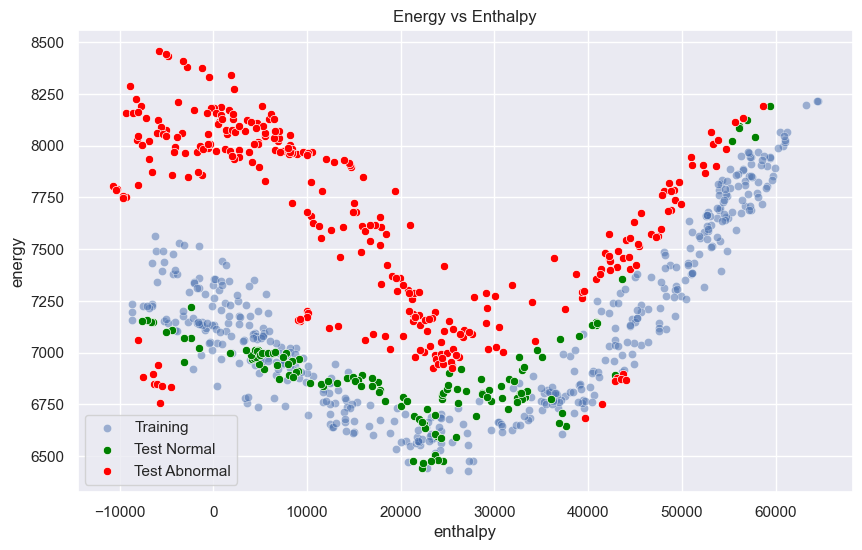

In [94]:
# Visual Assessment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
fig = plt.subplots(figsize=(10, 6))

ax1 = sns.scatterplot(data = train_df, x = 'enthalpy', y = 'energy', label = 'Training', alpha = 0.5)
ax2 = sns.scatterplot(data = test_df[test_df.anomaly == 1], x = 'enthalpy', y = 'energy', label = 'Test Normal', color = 'green')
ax3 = sns.scatterplot(data = test_df[test_df.anomaly == -1], x = 'enthalpy', y = 'energy', label = 'Test Abnormal', color = 'red')
_ = plt.title('Energy vs Enthalpy')



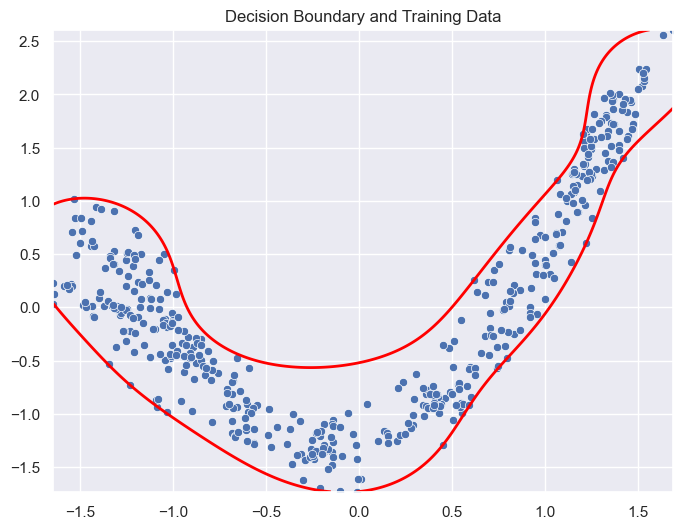

In [ ]:
# Visualize decision boudary
import numpy as np
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 0].min(), X_train_scaled[:, 0].max(), 500),
    np.linspace(X_train_scaled[:, 1].min(), X_train_scaled[:, 1].max(), 500)
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model.decision_function(grid)  # higher = more normal
Z = Z.reshape(xx.shape)


# Plot
plt.figure(figsize=(8,6))
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')  
ax1 = sns.scatterplot(x = X_train_scaled[:,0], y = X_train_scaled[:,1])
_ = plt.title('Decision Boundary and Training Data')

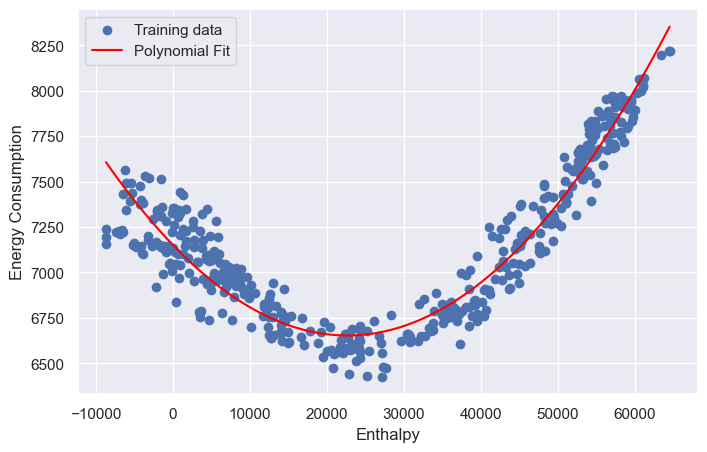

In [96]:
# Polynomial fit on training ata to filter "abnormally low" energy from data points flagged as abnormal

import numpy as np
x = train_df["enthalpy"]
y = train_df["energy"]
poly_fit = np.poly1d(np.polyfit(x, y, 2))

x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = poly_fit(x_fit)

plt.figure(figsize=(8, 5))
plt.scatter(x, y, label="Training data")
plt.plot(x_fit, y_fit, color="red", label="Polynomial Fit")
plt.xlabel("Enthalpy")
plt.ylabel("Energy Consumption")
plt.legend()



In [97]:
# Set lower energy consumption as normal
test_df['poly_fit'] = poly_fit(test_df['enthalpy'])
test_df.loc[test_df.energy < test_df.poly_fit, 'anomaly'] = 1

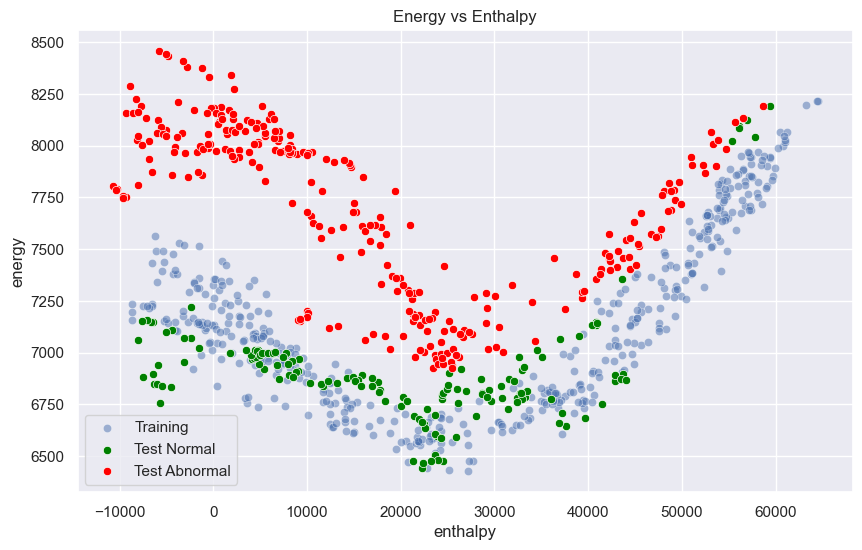

In [98]:
# Visual Assessment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
fig = plt.subplots(figsize=(10, 6))

ax1 = sns.scatterplot(data = train_df, x = 'enthalpy', y = 'energy', label = 'Training', alpha = 0.5)
ax2 = sns.scatterplot(data = test_df[test_df.anomaly == 1], x = 'enthalpy', y = 'energy', label = 'Test Normal', color = 'green')
ax3 = sns.scatterplot(data = test_df[test_df.anomaly == -1], x = 'enthalpy', y = 'energy', label = 'Test Abnormal', color = 'red')
_ = plt.title('Energy vs Enthalpy')

## Summary

- One-class SVM model + polynomial fit post processing seems to work well based on visual assessment
- Could play around with gamme and nu parameters to adjust sensitivity

In [100]:
# Save model

import pickle


with open('C:\\Users\\fsthilaire\\Desktop\\hd_energy_test\\src\\models\\SVM.pkl', 'wb') as f:
    pickle.dump(model, f)

In [114]:
ent = np.array(test_df['enthalpy'])
ene = np.array(test_df['energy'])
pol = poly_fit(ent)
anom = np.array(test_df.anomaly)
new_anom = anom.copy()
anom[ene < pol] = 0
anom

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1